# Tutorial of Creating OpenGeoSys Mesh with Borehole Heat Exchangers

This tutorial is made to illustrate the procedure of creating an OGS mesh file with Borehole Heat Exchangers (BHEs) in it. 
Such mesh uses prism elements for the soil part, and line elements for the BHEs. 
The produced mesh file is made explicitly for the HEAT_TRANSPORT_BHE module in OGS and will NOT work with other modules. 
Please refer to the [documentation](https://www.opengeosys.org/docs/processes/heat-transport/heat_transport_bhe/) of the HEAT_TRANSPORT_BHE process for more details of the project file configuration. 
For a better understanding of the mesh needed for this process, the following snapshot illustrates a 3D model domain with several BHEs in it. 
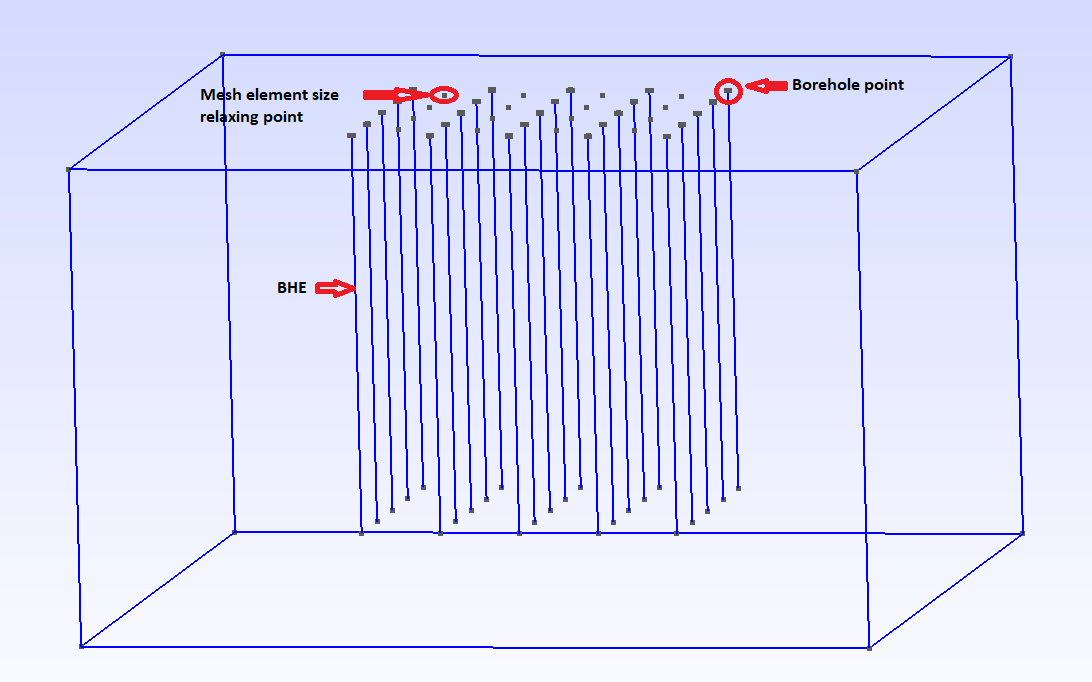
This tutorial contains two files, 
- [bhe_meshing.ipynb](./bhe_meshing.ipynb): This tutorial itself.
- [bhe_coordinates.xlsx](./bhe_coordinates.xlsx) :The spreadsheet file containing parameters of the BHEs. 

First, we import external packages, including Gmsh. 

In [1]:
%reset -f
import numpy as np
import pandas as pd
import gmsh
import sys
import os

Before using any functions in the Python API, Gmsh must be initialized.

In [2]:
gmsh.initialize()
gmsh.model.add("t1")

The geometry is a 3D structure that has 25 boreholes in it. Each borehole is represented by a line element where each line is created by adding two end points.  Each point requires an optional argument called 'tag'. 
It is a strictly positive integer that uniquely identifies the point. 
In this tutorial, we will use tags for all the borehole points so that we can identify any specific point. 
The first step is to create the surface 1 with all the necessary points. 
These points regulate the borehole locations, as well as the mesh size. 
Now we define the basic geometry of the BHEs, as well as the element sizes around them. 
For better optimal accuracy and better spatial discretizations, the mesh around the borehole point is designed according to relation (delta = alpha * bhe_radius) derived from Diersch et al. 2011 Part 2 (DOI:10.1016/j.cageo.2010.08.002)  where alpha = 6.134 for 6 surrounding nodes. 

In [3]:
#environment variable for output path
out_dir = os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out")
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

exe_dir = os.environ.get("OGS_BINARY_DIR")

# mesh file name
bhe_mesh_file_name = "bhe_mesh_file"

#geometry parameters
width = 200
length = 200
depth = 120
bhe_depth = depth - 20


#element sizes
bhe_radius = 0.07
alpha = 6.134                 # see Diersch et al. 2011 Part 2
delta = alpha * bhe_radius    # meshsize at BHE and distance of the surrounding optimal mesh points

elem_size_corner = 40
elem_size_BHE_relax = 2

In the following step, we are going to create the geometry of the bottom surface using the python interface of Gmsh. 

To create a point with the built-in CAD kernel, the Python API function `gmsh.model.geo.addPoint()` is used. 
- the first 3 arguments are the point coordinates (x, y, z)
- the next (optional) argument is the target mesh size close to the point
- the last (optional) argument is the point tag (a strictly positive integer that uniquely identifies the point)

Here, we have assigned 4 boundary points.  

In [4]:
gmsh.model.geo.addPoint(-width/2.0, 0.0, 0.0, elem_size_corner, 1)
gmsh.model.geo.addPoint(width/2.0, 0.0, 0.0, elem_size_corner, 2)
gmsh.model.geo.addPoint(width/2.0, length, 0.0, elem_size_corner, 3)
gmsh.model.geo.addPoint(-width/2.0, length, 0.0, elem_size_corner, 4)

4

Next, we need to create lines connecting the boundary points. 
The API to create straight-line segments with the built-in kernel follows the same conventions: 
the first 2 arguments are point tags (the start and end points of the line), and the last (optional) is the line tag. 
Note that curve tags are separate from point tags. Hence we can reuse tag '1' for our first curve. 
And as a general rule, elementary entity tags in Gmsh have to be unique per geometrical dimension.


In [5]:
gmsh.model.geo.addLine(1, 2, 1)
gmsh.model.geo.addLine(2, 3, 2)
gmsh.model.geo.addLine(3, 4, 3)
gmsh.model.geo.addLine(4, 1, 4)

4

Finally, we can create the surface 1. 
In order to define the surface using the four lines defined above, a curve loop must first be defined. 
An ordered list of connected curves defines a curve loop. 
The API function to create curve loops takes a list of integers as the first argument, and the curve loop tag (which must be unique amongst curve loops) as the second (optional) argument. 

We can then define the surface as a list of curve loops. 
Before the structure can be meshed, the CAD entities must be synchronized with the Gmsh model, which will create the relevant Gmsh data structures.
This is achieved by the API call `gmsh.model.geo.synchronize()`. Synchronizations can be called at any time. 


In [6]:
gmsh.model.geo.addCurveLoop([1, 2, 3, 4], 1)

gmsh.model.geo.addPlaneSurface([-1], 1)
gmsh.model.geo.synchronize()

Next step is to include 25 boreholes in this project, organized in a 5X5 array. 
The corresponding coordinates are imported from a Excel spreadsheet file. 

In [7]:
df_bhe = pd.read_excel('bhe_coordinates.xlsx')
df_relax = pd.read_excel('bhe_coordinates.xlsx', sheet_name=1)

Finally, all the borehole points and surrounding points are added to the surface 1. 
Here, 6 surrounding points for each borehole point are added with hexagonal shape like in this picture.
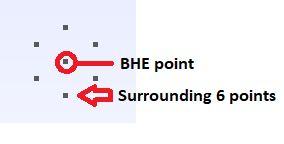
A detailed explanation and model verification can be found in Diersch et al. (2011).
Here, the initial borehole point tag can not be smaller than 4 since there are already four boundary points. 

In [8]:
x=df_bhe['X']   # X-coordinates
y=df_bhe['Y']   # Y-coordinates
z=df_bhe['Z']   # Z-coordinates
d=5             # initial borehole point tag

j=[]
for i in range(len(x)):
    X=x[i]
    Y=y[i]
    Z=z[i]

    gmsh.model.geo.addPoint(X, Y, Z, delta, d)                            # Diersch et al. 2011 Part 2
    
    gmsh.model.geo.addPoint(X, Y - delta, Z, delta, d+1)
    gmsh.model.geo.addPoint(X, Y + delta, Z, delta, d+2)
    
    gmsh.model.geo.addPoint(X+0.866*delta, Y + 0.5*delta, Z, delta, d+3)
    gmsh.model.geo.addPoint(X-0.866*delta, Y + 0.5*delta, Z, delta, d+4)
    
    gmsh.model.geo.addPoint(X+0.866*delta, Y - 0.5*delta, Z, delta, d+5)
    gmsh.model.geo.addPoint(X-0.866*delta, Y - 0.5*delta, Z, delta, d+6)
    
    j.append(d)
    gmsh.model.geo.synchronize()
    gmsh.model.mesh.embed(0,[d, d+1, d+2, d+3, d+4, d+5, d+6],2,1)
    
    d = d+7

In this step, all mesh element size relaxing points have been added and embedded in surface 1.

In [9]:
x=df_relax['X']   # X-coordinates
y=df_relax['Y']   # Y-coordinates
z=df_relax['Z']   # Z-coordinates

for i in range(len(x)):
    X=x[i]
    Y=y[i]
    Z=z[i]

    gmsh.model.geo.addPoint(X, Y, Z, elem_size_BHE_relax, d)
    gmsh.model.geo.synchronize()
    gmsh.model.mesh.embed(0,[d],2,1)
    d = d+1

Now, the 'gmsh.model.geo.extrude' command extrudes the surface 1 along the z axis and automatically creates a new volume (as well as all the needed points, curves and surfaces). The function takes a vector of (dim, tag) pairs as input as well as the translation vector, and returns a vector of (dim, tag) pairs as output. 

The 2D mesh extrusion is done with the same 'extrude()' function, but by specifying element 'Layers' (Here, one layer each with 12 subdivisions with a total height of 120). The number of elements for each layer and the (end) height of each layer are specified in two vectors. 
The last (optional) argument for the extrude() function specifies whether the extruded mesh should be recombined or not. 
In this case, it is 'True' since we want to recombine and produce prism mesh elements. 

Later 'gmsh.model.addPhysicalGroup' command used to group elementary geometrical entities into more meaningful groups, e.g. to define some mathematical ("domain", "boundary"), functional ("left wing", "fuselage") or material ("steel", "carbon") properties. Gmsh will export in output files only mesh elements that belong to at least one physical group. Physical groups are also identified by tags, i.e. strictly positive integers, that should be unique per dimension (0D, 1D, 2D or 3D).



In [10]:
gmsh.model.geo.synchronize()
R = gmsh.model.geo.extrude([(2, 1)], 0, 0, -depth, [12], [1], True)
gmsh.model.addPhysicalGroup(3, [R[1][1]], 1)


1

In this step, all bhe point will be extruded up to bhe_depth and each bhe line will be assigned unique physical group.

In [11]:
k= 2
for u in j:
    G = gmsh.model.geo.extrude([(0, u)], 0, 0, -bhe_depth, [10], [1], True)
    gmsh.model.addPhysicalGroup(1, [G[1][1]], k)
    k = k + 1
gmsh.model.geo.synchronize()

Meshes generated with Gmsh must be converted to VTU file format later. Currently, the only supported Gmsh format is 2.2

In [12]:
gmsh.option.setNumber("Mesh.MshFileVersion", 2.2)

Then We can then generate a 3D mesh and save it to disk

In [13]:
gmsh.model.mesh.generate(3)

gmsh.model.mesh.removeDuplicateNodes()

gmsh.write(f"{out_dir}/{bhe_mesh_file_name}.msh")

Launch the GUI to see the results. Later gmsh.finalize() will be called when done using GMSH Python API

In [14]:
if '-nopopup' not in sys.argv:
    gmsh.fltk.run()
    
    
gmsh.finalize()

If everything runs well, you will see the following mesh. 
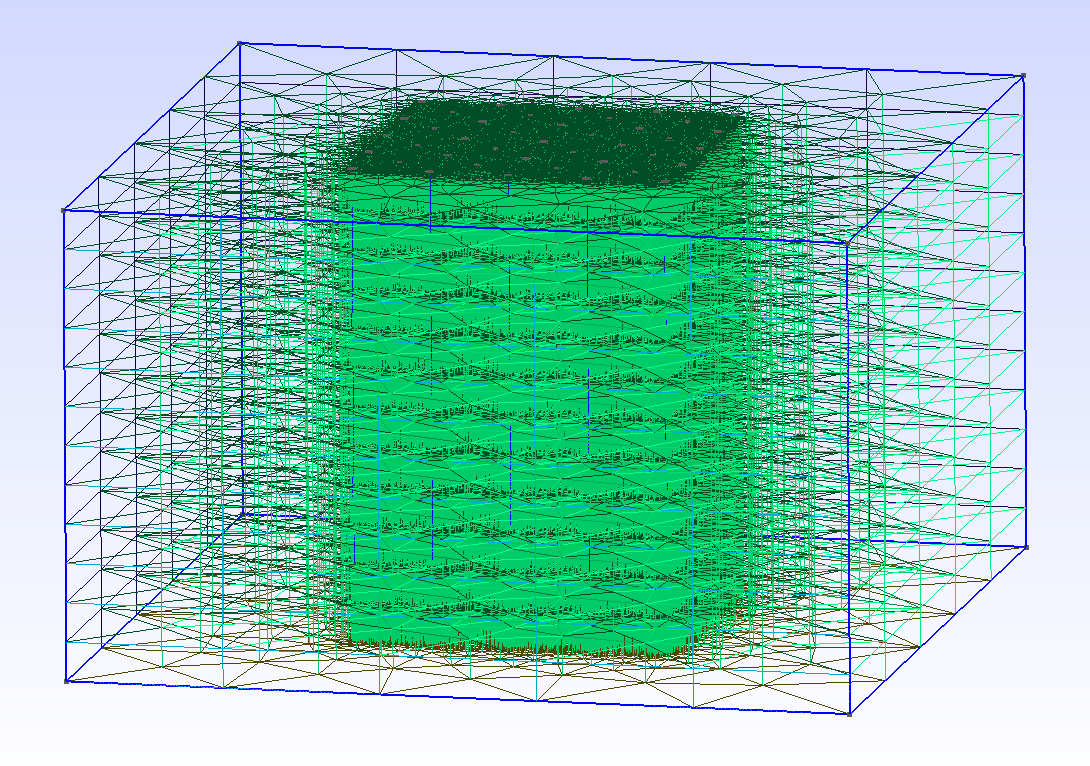

Now checking whether the Gmsh format mesh file is properly created. If not give an error message. 

In [15]:
check_file = os.path.isfile(f"{out_dir}/{bhe_mesh_file_name}.msh")
if check_file:
    print("Creation of BHE mesh in Gmsh format was successful.")
else:
    raise Exception("Error! Gmsh file is not properly created in the BHE meshing tutorial.")

Creation of BHE mesh in Gmsh format was successful.


In this step, we will investigate the number of nodes, lines, prisms, and Material ID of the created mesh file, to validate if it is created properly for simulation.

In [16]:
gmsh.initialize()
gmsh.open(f"{out_dir}/{bhe_mesh_file_name}.msh")
nodeTags, coord, parametricCoord = gmsh.model.mesh.getNodes(-1,-1)
elemTypes, line_elemTags, elemNodeTags =gmsh.model.mesh.getElements(1,-1)
elemTypes, volume_elemTags, elemNodeTags =gmsh.model.mesh.getElements(3,-1)
dimTags = gmsh.model.getPhysicalGroups(1)
Material_ID = len(dimTags)
gmsh.finalize()

if (np.size(nodeTags) == 119886) and (np.size(line_elemTags) == 250) and (np.size(volume_elemTags)==221064) and (Material_ID == 25) : 
    print("Total Nodes", np.size(nodeTags))
    print("Nr of lines", np.size(line_elemTags))
    print("Nr. of prisms", np.size(volume_elemTags))
    print("Material ID", Material_ID)
else:
    raise Exception("Error! The number of nodes, elements and Material_IDs in the generated Gmsh file is not correct.")

Total Nodes 119886
Nr of lines 250
Nr. of prisms 221064
Material ID 25


Finally, the mesh file which has been created using the Python interface of Gmsh, will be converted to OGS mesh, in particular to VTU file format. 
Please, add the executable GMSH2OGS to the directory of this example file, or add the path to the OGS binary folder into the running environment. 
Here, option -v (--validation) validates the mesh and shows crucial information about the mesh. 
Option -i takes gmsh input file name as a string and -o is the output file name as a string as well

In [17]:
!GMSH2OGS -i {out_dir}/{bhe_mesh_file_name}.msh -o {out_dir}/{bhe_mesh_file_name}.vtu -v

[2023-10-03 15:28:50.168] [ogs] [info] Reading _out/bhe_mesh_file.msh.
[2023-10-03 15:28:54.056] [ogs] [info] 	... finished.
[2023-10-03 15:28:54.056] [ogs] [info] Nr. Nodes: 119886.
[2023-10-03 15:28:54.056] [ogs] [info] Nr. Elements: 221314.
[2023-10-03 15:28:54.064] [ogs] [info] Time for reading: 3.894933 seconds.
[2023-10-03 15:28:54.064] [ogs] [info] Read 119886 nodes and 221314 elements.
[2023-10-03 15:28:54.064] [ogs] [info] Please check your mesh carefully!
[2023-10-03 15:28:54.064] [ogs] [info] Degenerated or redundant mesh elements can cause OGS to stop or misbehave.
[2023-10-03 15:28:54.064] [ogs] [info] Use the -e option to delete redundant line elements.
[2023-10-03 15:28:54.065] [ogs] [info] Node coordinates:
[2023-10-03 15:28:54.065] [ogs] [info] 	x [-100, 100] (extent 200)
[2023-10-03 15:28:54.065] [ogs] [info] 	y [0, 200] (extent 200)
[2023-10-03 15:28:54.065] [ogs] [info] 	z [-120, 4.94066e-324] (extent 120)
[2023-10-03 15:28:54.065] [ogs] [info] Edge length: [0.28471

The above conversion tool also shows that there exist 250 lines and 221064 prism elements. 
An assertion check is added here to make sure that the VTU format mesh file is properly created.  

In [18]:
check_file = os.path.isfile(f"{out_dir}/{bhe_mesh_file_name}.vtu")
if check_file:
    print("Conversion of mesh file from Gmsh to VTU format was successful.")
else:
    raise Exception("Error! Gmsh file is not properly converted to VTU format in the BHE meshing tutorial.")

Conversion of mesh file from Gmsh to VTU format was successful.
